In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as pyplot
import tinyarray
%matplotlib inline
import scipy
from tqdm.notebook import tqdm,trange

/Users/caijiaqi/opt/anaconda3/lib/python3.7/site-packages/kwant/solvers/default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
hamiltonian = """
vf*(k_y*kron(sigma_0,sigma_x) - k_x*kron(sigma_0,sigma_y))+ (m0-m1*(k_x**2+k_y**2))*kron(sigma_z,sigma_z) 
+ Mz(x,y)*kron(sigma_0,sigma_z) 
+ Ud(x,y)*kron(sigma_x,sigma_0) + Ua(x,y)*kron(sigma_0,sigma_0)
+ Ug*kron((sigma_z + sigma_0)/2, sigma_0)
"""
# kinetic term + SOC term 
# + magnetic term
# + random SIA term + random diagonal term
# + gate voltage
a = 1
r = 30
W = 24
L = 24
cell_size=4
num_cell = W/cell_size
M_model = 3

def rand_bin_array(num_of_true,N):
    N = int(N)
    arr = np.zeros(N*N)
    arr[:num_of_true]  = 1
    np.random.shuffle(arr)
    return np.reshape(arr,[N,N])
def U_father(x,y,strength,matrix):
    return strength/2*matrix[int(x),int(y)]

def Mz_father(x,y,cell_array,cell_size):
    m = int(x//cell_size)
    n = int(y//cell_size)
    if cell_array[m,n]:
        return M_model
    else:
        return -M_model

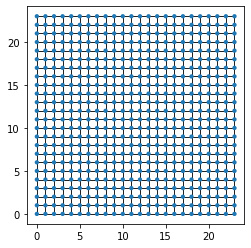

/Users/caijiaqi/opt/anaconda3/lib/python3.7/site-packages/kwant/kpm.py:997: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((energy - mu) / temperature))


In [4]:
# fermi surface dependent
template = kwant.continuum.discretize(hamiltonian,grid = a)
lat = template.lattice
def circle(site):
    x,y = site.pos
    return (x**2 + y**2 <= r**2)
def rect(site):
    x,y= site.pos
    return (0 <= y <W and 0 <=x <L)
syst = kwant.Builder()
syst.fill(template,rect,(0,0))
syst.eradicate_dangling()
kwant.plot(syst)
syst_without_lead = syst.finalized()

avg_num = 10
strength = 1
Ug = 0
energies = np.linspace(-2,2,100)
xx_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
xy_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
for num_of_up in trange(int(num_cell*num_cell/2),int(num_cell*num_cell)):
    temp_xx = 0
    temp_xy = 0
    index = num_of_up - int(num_cell*num_cell/2)
    for k in trange(avg_num,leave=False):
        up_down_array = rand_bin_array(num_of_up,num_cell)
        Mz = lambda x,y : Mz_father(x,y,up_down_array,cell_size)
        Md = np.random.uniform(-1,1,size = (W,L))
        Ma = np.random.uniform(-1,1,size = (W,L))
        Ud  = lambda x,y : U_father(x,y,strength,Md)
        Ua = lambda x,y : U_father(x,y,strength,Ma)
        params = {'vf':1,'m1':1,'m0':-0.5,'Mz':Mz,'Ua':Ua,'Ud':Ud,'Ug':Ug}
        cond_xx = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'x',params=params)
        cond_xy = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'y',params=params)
        temp_xx += np.array([cond_xx(e,temperature = 1E-6) for e in energies])
        temp_xy += np.array([cond_xy(e,temperature = 1E-6) for e in energies])
    xx_list[index,:] = temp_xx/(avg_num*W*L)
    xy_list[index,:] = temp_xy/(avg_num*W*L)

In [5]:
num_of_up = np.arange(int(num_cell*num_cell/2),int(num_cell*num_cell))
avg_mag = (num_of_up*M_model - (num_cell*num_cell - num_of_up)*M_model)/(num_cell*num_cell)

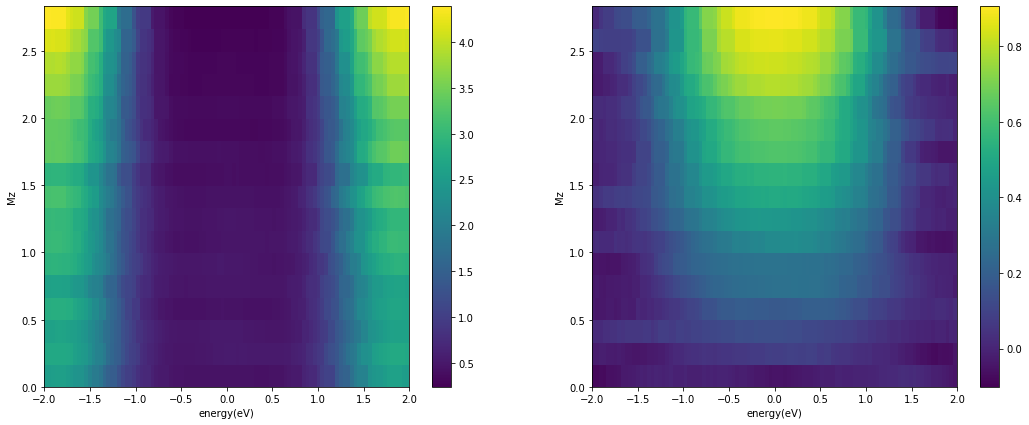

In [6]:
fig,(ax1,ax2) = pyplot.subplots(1,2,figsize = (18,7))
plt = ax1.pcolor(energies,avg_mag,np.real(xx_list))
plt2 = ax2.pcolor(energies,avg_mag,np.real(xy_list))
ax1.set_xlabel('energy(eV)')
ax1.set_ylabel('Mz')
ax2.set_xlabel('energy(eV)')
ax2.set_ylabel('Mz')
cbar = fig.colorbar(plt,ax = ax1)
cbar = fig.colorbar(plt2,ax = ax2)

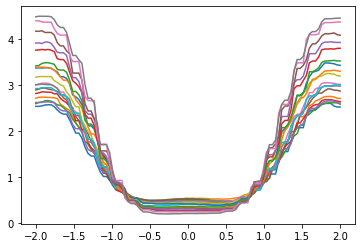

In [7]:
fig,ax = pyplot.subplots()
plt = ax.plot(energies,np.real(xx_list).T)

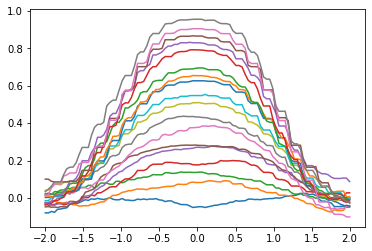

In [8]:
fig,ax = pyplot.subplots()
plt = ax.plot(energies,np.real(xy_list).T)

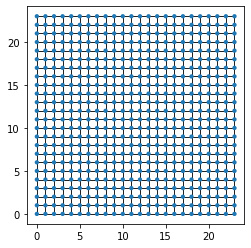

KeyboardInterrupt: 

In [126]:
# gate surface dependent
template = kwant.continuum.discretize(hamiltonian,grid = a)
lat = template.lattice
def circle(site):
    x,y = site.pos
    return (x**2 + y**2 <= r**2)
def rect(site):
    x,y= site.pos
    return (0 <= y <W and 0 <=x <L)
syst = kwant.Builder()
syst.fill(template,rect,(0,0))
syst.eradicate_dangling()
kwant.plot(syst)
syst_without_lead = syst.finalized()

avg_num = 10
strength = 1
gate_list = np.linspace(-2,2,100)

xx_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
xy_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
num_of_up = np.arange(int(num_cell*num_cell/2),int(num_cell*num_cell))
avg_mag = (num_of_up*M_model - (num_cell*num_cell - num_of_up)*M_model)/(num_cell*num_cell)

for num_of_up in trange(int(num_cell*num_cell/2),int(num_cell*num_cell)):
    temp_xx = 0
    temp_xy = 0
    index = num_of_up - int(num_cell*num_cell/2)
    for k in trange(avg_num,leave=False):
        up_down_array = rand_bin_array(num_of_up,num_cell)
        Mz = lambda x,y : Mz_father(x,y,up_down_array,cell_size)
        Md = np.random.uniform(-1,1,size = (W,L))
        Ma = np.random.uniform(-1,1,size = (W,L))
        Ud  = lambda x,y : U_father(x,y,strength,Md)
        Ua = lambda x,y : U_father(x,y,strength,Ma)
        temp_xx = np.zeros((1,100),dtype = complex)
        temp_xy = np.zeros((1,100),dtype = complex)
        for (m,gate_voltage) in enumerate(gate_list):
            params = {'vf':1,'m1':1,'m0':-0.5,'Mz':Mz,'Ua':Ua,'Ud':Ud,'Ug':gate_voltage}
            cond_xx = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'x',params=params)
            cond_xy = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'y',params=params)
            temp_xx[0,m] = cond_xx(0,temperature = 1E-6)
            temp_xy[0,m] = cond_xy(0,temperature = 1E-6)
    xx_list[index,:] = temp_xx/(avg_num*W*L)
    xy_list[index,:] = temp_xy/(avg_num*W*L)

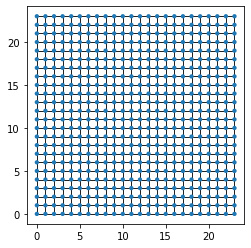

/Users/caijiaqi/opt/anaconda3/lib/python3.7/site-packages/kwant/kpm.py:997: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp((energy - mu) / temperature))


In [14]:
# fermi surface-gate voltage data dependent
# fermi surface dependent
import scipy.io as sio
from os import path

template = kwant.continuum.discretize(hamiltonian,grid = a)
lat = template.lattice
def circle(site):
    x,y = site.pos
    return (x**2 + y**2 <= r**2)
def rect(site):
    x,y= site.pos
    return (0 <= y <W and 0 <=x <L)
syst = kwant.Builder()
syst.fill(template,rect,(0,0))
syst.eradicate_dangling()
kwant.plot(syst)
syst_without_lead = syst.finalized()

avg_num = 10
strength = 1
gate_list = np.linspace(-2,2,100)

energies = np.linspace(-2,2,100)

num_of_up = np.arange(int(num_cell*num_cell/2),int(num_cell*num_cell))
avg_mag = (num_of_up*M_model - (num_cell*num_cell - num_of_up)*M_model)/(num_cell*num_cell)

for gate in gate_list:
    xx_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
    xy_list = np.zeros((int(num_cell*num_cell/2),100),dtype = complex)
    for num_of_up in trange(int(num_cell*num_cell/2),int(num_cell*num_cell)):
        temp_xx = 0
        temp_xy = 0
        index = num_of_up - int(num_cell*num_cell/2)
        for k in trange(avg_num,leave=False):
            up_down_array = rand_bin_array(num_of_up,num_cell)
            Mz = lambda x,y : Mz_father(x,y,up_down_array,cell_size)
            Md = np.random.uniform(-1,1,size = (W,L))
            Ma = np.random.uniform(-1,1,size = (W,L))
            Ud  = lambda x,y : U_father(x,y,strength,Md)
            Ua = lambda x,y : U_father(x,y,strength,Ma)
            params = {'vf':1,'m1':1,'m0':-0.5,'Mz':Mz,'Ua':Ua,'Ud':Ud,'Ug':gate}
            cond_xx = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'x',params=params)
            cond_xy = kwant.kpm.conductivity(syst_without_lead, alpha = 'x',beta = 'y',params=params)
            temp_xx += np.array([cond_xx(e,temperature = 1E-6) for e in energies])
            temp_xy += np.array([cond_xy(e,temperature = 1E-6) for e in energies])
            
        xx_list[index,:] = temp_xx/(avg_num*W*L)
        xy_list[index,:] = temp_xy/(avg_num*W*L)
    sio.savemat("data\\"+str(gate)+".mat",{'xx':xx_list,'xy':xy_list,'E':energies,'M':avg_mag})

In [20]:
for gate in gate_list:
    a = sio.loadmat("data\\"+str(gate)+".mat",{'xx':xx_list,'xy':xy_list,'E':energies,'M':avg_mag})
    sio.savemat("data/"+str(gate)+".mat",a)